In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [2]:
import os
import torch
import torchvision
import tarfile

In [3]:
from torchvision.datasets.utils import download_url

In [4]:
url="https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(url, '.') 

100%|██████████| 135M/135M [00:06<00:00, 20.6MB/s] 


In [6]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path = './data')

In [7]:
data_dir="./data/cifar10"
print (os.listdir(data_dir))

classes=os.listdir(data_dir+'/train')
print (classes)

['train', 'test']
['ship', 'frog', 'airplane', 'bird', 'deer', 'dog', 'truck', 'horse', 'automobile', 'cat']


In [8]:
for type_class in classes:
    train_dir_path = f'./data/cifar10/train/{type_class}'
    test_dir_path= f'./data/cifar10/test/{type_class}'
    num_train = len(os.listdir(train_dir_path))
    num_test=len(os.listdir(test_dir_path))
    print(f"{type_class} => Training: {num_train} , Testing: {num_test}")

ship => Training: 5000 , Testing: 1000
frog => Training: 5000 , Testing: 1000
airplane => Training: 5000 , Testing: 1000
bird => Training: 5000 , Testing: 1000
deer => Training: 5000 , Testing: 1000
dog => Training: 5000 , Testing: 1000
truck => Training: 5000 , Testing: 1000
horse => Training: 5000 , Testing: 1000
automobile => Training: 5000 , Testing: 1000
cat => Training: 5000 , Testing: 1000


In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [21]:
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Use ImageNet normalization and resize to 299x299 for Inception
inception_trans = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

batch_size=8

train_ds = ImageFolder(data_dir+'/train', transform=inception_trans)
val_ds = ImageFolder(data_dir+'/test', transform=inception_trans)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

# Model
inception = models.inception_v3(pretrained=True, aux_logits=True)
inception.fc = nn.Linear(inception.fc.in_features, 10)
model = inception.to(device)

In [22]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(valid_dl, device)
to_device(model, device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [28]:
def loss_batch(model, loss_func, x, y, opt = None, metric = None):
    pred = model(x)
    if isinstance(pred, tuple):
        main_out, aux_out = pred
        loss = loss_func(main_out, y) + 0.4 * loss_func(aux_out, y)
        pred_for_metric = main_out
    else:
        loss = loss_func(pred, y)
        pred_for_metric = pred

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        metric_result = metric(pred_for_metric, y)
        
    return loss.item(), len(x), metric_result

In [29]:
def evaluate(model, loss_fn, val_dl, metric = None):
    
    with torch.no_grad():
        
        results = [loss_batch(model, loss_fn, x, y, metric = metric) for x, y in val_dl]
        
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        
        avg_metric = None
        
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
            
    return avg_loss, total, avg_metric

In [30]:
def fit(epochs, model, loss_fn, train_dl, val_dl, opt_fn = None, metric = None, scheduler = None, scheduler_on = 'val_metric'):
    
    train_losses, val_losses, val_metrics = [], [], []
    
    
    for epoch in range(epochs):
        
        model.train()
        for x, y in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, x, y, opt_fn)
            
        model.eval()
        result = evaluate(model, loss_fn, val_dl, metric)
        val_loss, total, val_metric = result
        
        train_losses.append(train_loss)
        val_losses.append(val_losses)
        val_metrics.append(val_metric)
        
        if metric is None:
            print('Epoch{}/{}, train_loss: {:.4f}, val_loss: {:.4f}' 
                 .format(epoch+1, epochs, train_loss, val_loss))
            
        else:
            print('Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}'
                 .format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
            
        if scheduler is not None:
            if scheduler_on == 'val_metric':
                scheduler.step(val_metrics[-1])
        
            
    return train_losses, val_losses, val_metrics

In [31]:
def accuracy(output, labels):
    _, preds = torch.max(output, dim = 1)
    
    return torch.sum(preds == labels).item() / len(preds)

In [32]:
import torch.nn.functional as F
val_loss, _, val_acc = evaluate(model, F.cross_entropy, val_dl, metric = accuracy)

print(val_loss, val_acc)

5.636158447265625 0.1005


In [33]:
num_epochs = 5

optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, mode = 'max', verbose = True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [34]:
history = fit(num_epochs, model, F.cross_entropy, train_dl, val_dl, optimizer, accuracy, scheduler, 'val_metric')

Epoch 1/5, train_loss: 2.0787, val_loss: 1.7892, val_accuracy: 0.3364
Epoch 2/5, train_loss: 2.3619, val_loss: 1.5830, val_accuracy: 0.4442
Epoch 3/5, train_loss: 1.3459, val_loss: 1.4103, val_accuracy: 0.5432
Epoch 4/5, train_loss: 1.4198, val_loss: 1.3243, val_accuracy: 0.6475
Epoch 5/5, train_loss: 2.4433, val_loss: 0.8881, val_accuracy: 0.7014


Text(0.5, 1.0, 'Plot between Training Loss vs Epochs')

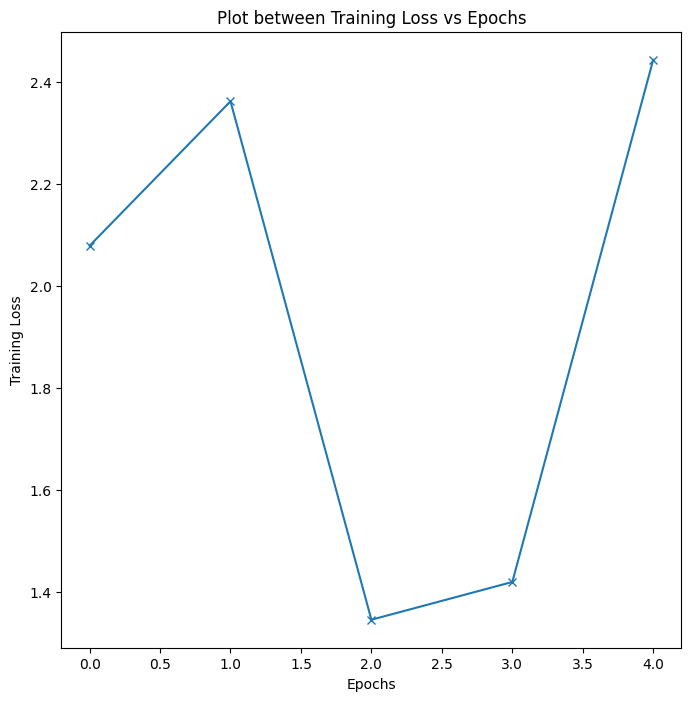

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,8))
plt.plot(history[0], '-x')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Plot between Training Loss vs Epochs')

Text(0.5, 1.0, 'Plot between Validation Loss vs Epochs')

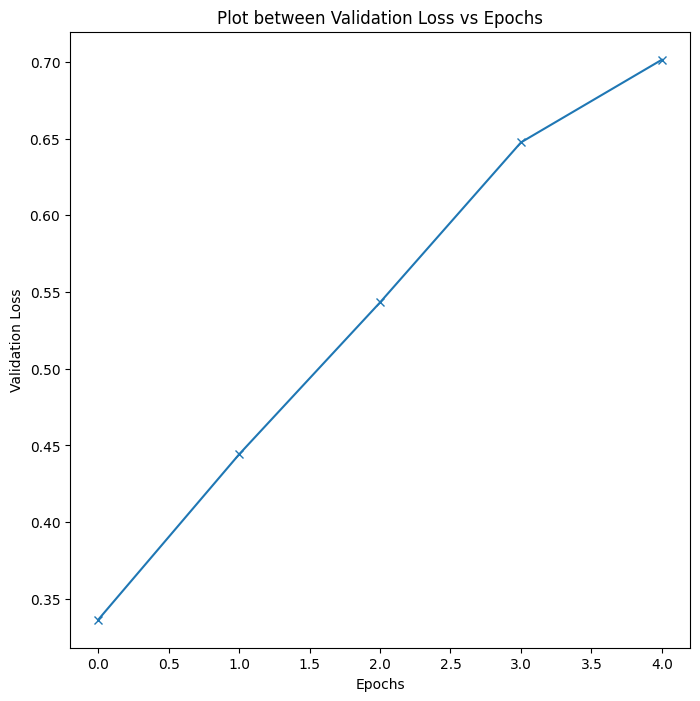

In [36]:
plt.figure(figsize = (8,8))
plt.plot(history[2], '-x')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Plot between Validation Loss vs Epochs')